In [1]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
import IPython

import utils
from dataset_generator import DatasetGenerator

os.chdir('../..') 

2023-04-27 23:49:41.462480: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 23:49:42.349112: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
price_dfs = utils.load_data('prices')
quarterly_financials_dfs = utils.load_data('quarterly_financials')

dfs = []
for (price_df, quarterly_financials_df) in zip(price_dfs, quarterly_financials_dfs):
    price_df = utils.clean_price_df(price_df)
    quarterly_financials_df = utils.clean_quarterly_financials_df(quarterly_financials_df)

    df = utils.join_quarterly_financials_df(price_df, quarterly_financials_df)

    df = df.drop(["Date", "end_date"])

    dfs.append(df)

train_dfs, val_dfs, test_dfs = utils.setup_data(dfs, .7, .2)

column_indices = {name: i for i, name in enumerate(train_dfs[0].columns)}


argument in operation 'asof_join' is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an error in a future version.
    
argument in operation 'asof_join' is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an error in a future version.
    
argument in operation 'asof_join' is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an error in a future version.
    
argument in operation 'asof_join' is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an 

In [3]:
label_columns = ['Adj Close']

single_step_window = DatasetGenerator(train_dfs, val_dfs, test_dfs, 1, 1, 1, label_columns)

wide_window = DatasetGenerator(train_dfs, val_dfs, test_dfs,  20, 20, 1, label_columns)

CONV_WIDTH = 3
conv_window = DatasetGenerator(train_dfs, val_dfs, test_dfs, CONV_WIDTH, 1, 1, label_columns)

LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = DatasetGenerator(train_dfs, val_dfs, test_dfs, INPUT_WIDTH, LABEL_WIDTH, 1, label_columns)

2023-04-27 23:49:43.842432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-27 23:49:43.869815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-27 23:49:43.870188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Zero Predictor

In [ ]:
class Zero(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        result = result[:, :, tf.newaxis]
        
        return tf.zeros_like(result, tf.int32)
                    

In [ ]:
zero = Zero(label_index=column_indices['Adj Close'])

zero.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Zero'] = zero.evaluate(single_step_window.val)
performance['Zero'] = zero.evaluate(single_step_window.test, verbose=0)

315/315 [==============================] - 1s 3ms/step - loss: 0.8189 - mean_absolute_error: 0.9014


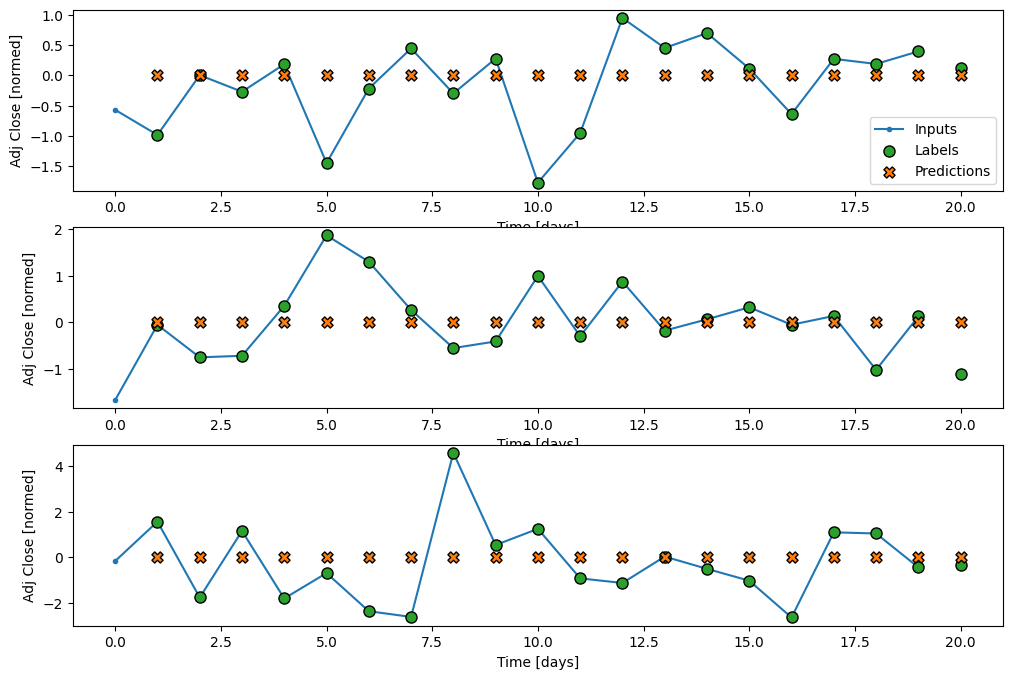

In [ ]:
wide_window.windows[0].plot(zero)

### Baseline

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [ ]:
baseline = Baseline(label_index=column_indices['Adj Close'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


2023-04-27 22:24:23.988262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_332' with dtype int32
	 [[{{node Placeholder/_332}}]]
2023-04-27 22:24:23.990851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_327' with dtype int32 and shape [708]
	 [[{{node Placeholder/_327}}]]


315/315 [==============================] - 1s 2ms/step - loss: 4.4578 - mean_absolute_error: 1.3542


2023-04-27 22:24:25.071419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_263' with dtype int32 and shape [275]
	 [[{{node Placeholder/_263}}]]
2023-04-27 22:24:25.077524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_364' with dtype int32
	 [[{{node Placeholder/_364}}]]


In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

2023-04-27 22:24:25.726115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2460]
	 [[{{node Placeholder/_8}}]]
2023-04-27 22:24:25.726493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


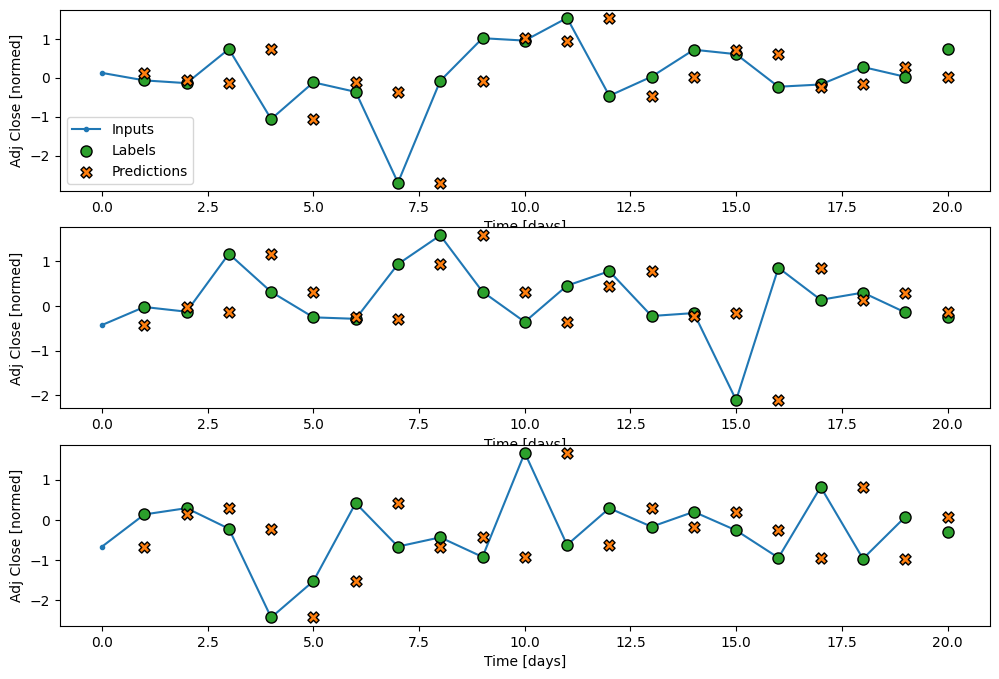

In [ ]:
wide_window.windows[0].plot(baseline)

### Linear

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


2023-04-27 22:24:26.849746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2480,13]
	 [[{{node Placeholder/_0}}]]
2023-04-27 22:24:26.852246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_300' with dtype int32
	 [[{{node Placeholder/_300}}]]
2023-04-27 22:24:28.353039: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x2833bf20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-27 22:24:28.353111: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Co

1070/1070 [==============================] - 6s 4ms/step - loss: 1.1907 - mean_absolute_error: 0.7659 - val_loss: 2.0359 - val_mean_absolute_error: 0.9288
Epoch 2/20
1070/1070 [==============================] - 4s 4ms/step - loss: 1.0133 - mean_absolute_error: 0.7046 - val_loss: 1.9853 - val_mean_absolute_error: 0.9144
Epoch 3/20
1070/1070 [==============================] - 4s 4ms/step - loss: 1.0054 - mean_absolute_error: 0.7019 - val_loss: 1.9665 - val_mean_absolute_error: 0.9106
Epoch 4/20
1070/1070 [==============================] - 4s 4ms/step - loss: 1.0020 - mean_absolute_error: 0.7006 - val_loss: 1.9509 - val_mean_absolute_error: 0.9072
Epoch 5/20
1070/1070 [==============================] - 4s 4ms/step - loss: 1.0004 - mean_absolute_error: 0.7001 - val_loss: 1.9448 - val_mean_absolute_error: 0.9060
Epoch 6/20
1070/1070 [==============================] - 4s 4ms/step - loss: 0.9997 - mean_absolute_error: 0.6997 - val_loss: 1.9359 - val_mean_absolute_error: 0.9037
Epoch 7/20
1070

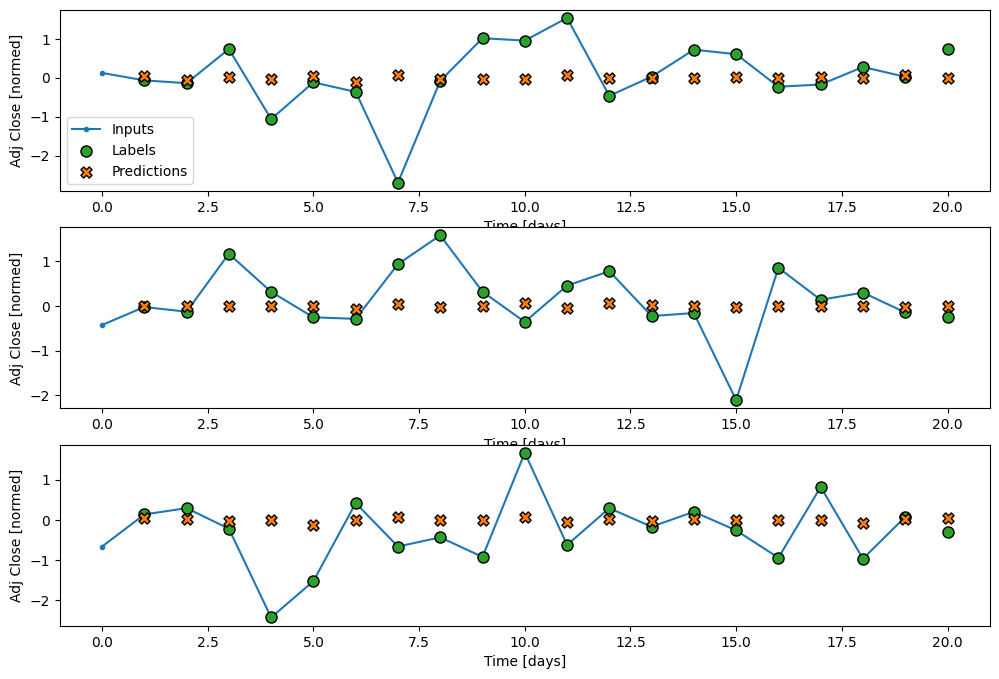

In [ ]:
wide_window.windows[0].plot(linear)

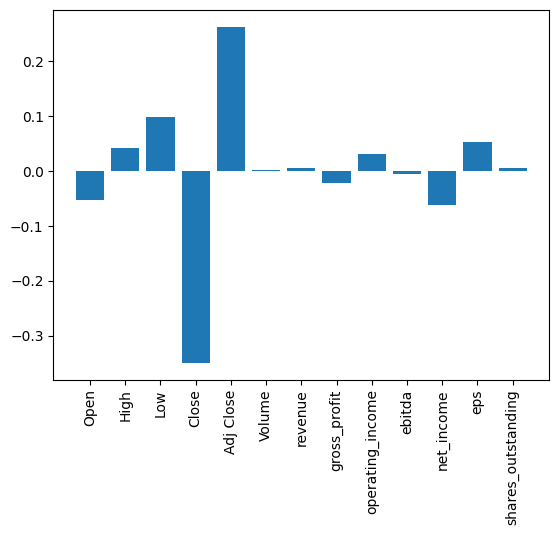

In [ ]:
plt.bar(x = range(len(train_dfs[0].columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_dfs[0].columns)))
_ = axis.set_xticklabels(train_dfs[0].columns, rotation=90)

### Dense

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1070/1070 [==============================] - 8s 6ms/step - loss: 1.0158 - mean_absolute_error: 0.7070 - val_loss: 1.9599 - val_mean_absolute_error: 0.9108
Epoch 2/20
1070/1070 [==============================] - 6s 5ms/step - loss: 1.0011 - mean_absolute_error: 0.7011 - val_loss: 1.9445 - val_mean_absolute_error: 0.9030
Epoch 3/20
1070/1070 [==============================] - 6s 5ms/step - loss: 0.9952 - mean_absolute_error: 0.6992 - val_loss: 1.9370 - val_mean_absolute_error: 0.9021
Epoch 4/20
1070/1070 [==============================] - 7s 6ms/step - loss: 0.9929 - mean_absolute_error: 0.6982 - val_loss: 1.9372 - val_mean_absolute_error: 0.9013
Epoch 5/20
315/315 [==============================] - 1s 4ms/step - loss: 1.9408 - mean_absolute_error: 0.9024


### Multi-step Dense

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

315/315 [==============================] - 1s 4ms/step - loss: 1.9665 - mean_absolute_error: 0.9144


2023-04-27 22:27:00.097186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [352]
	 [[{{node Placeholder/_8}}]]
2023-04-27 22:27:00.102566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_364' with dtype int32
	 [[{{node Placeholder/_364}}]]


2023-04-27 22:27:01.006579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2477]
	 [[{{node Placeholder/_8}}]]
2023-04-27 22:27:01.007117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


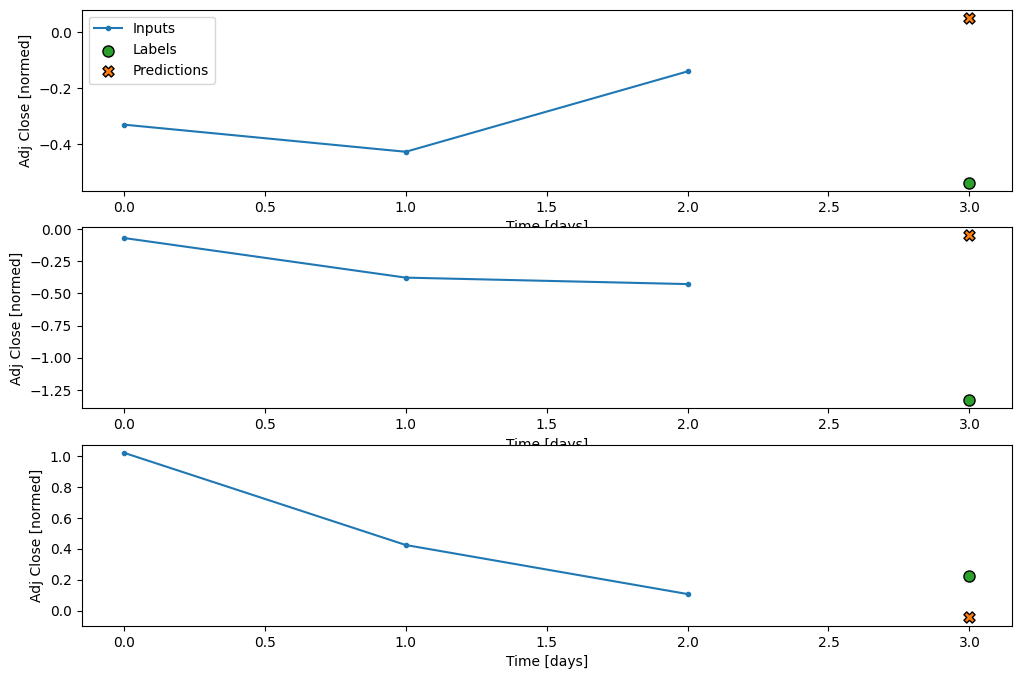

In [ ]:
conv_window.windows[0].plot(multi_step_dense)

### Convolutional Neural Network

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

315/315 [==============================] - 1s 4ms/step - loss: 1.9460 - mean_absolute_error: 0.9099


2023-04-27 22:27:51.894811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-04-27 22:27:51.895494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


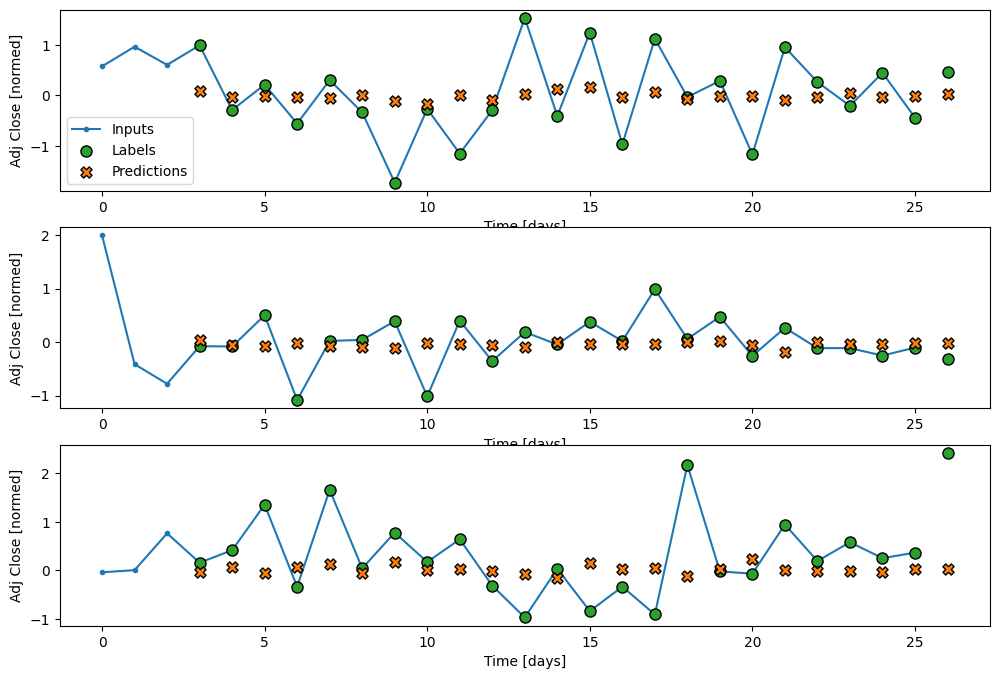

In [ ]:
wide_conv_window.windows[0].plot(conv_model)

### LSTM

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(4, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

301/301 [==============================] - 1s 4ms/step - loss: 1.9925 - mean_absolute_error: 0.9214


2023-04-27 22:28:24.886504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_167' with dtype int32 and shape [339]
	 [[{{node Placeholder/_167}}]]
2023-04-27 22:28:24.891284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_236' with dtype int32
	 [[{{node Placeholder/_236}}]]


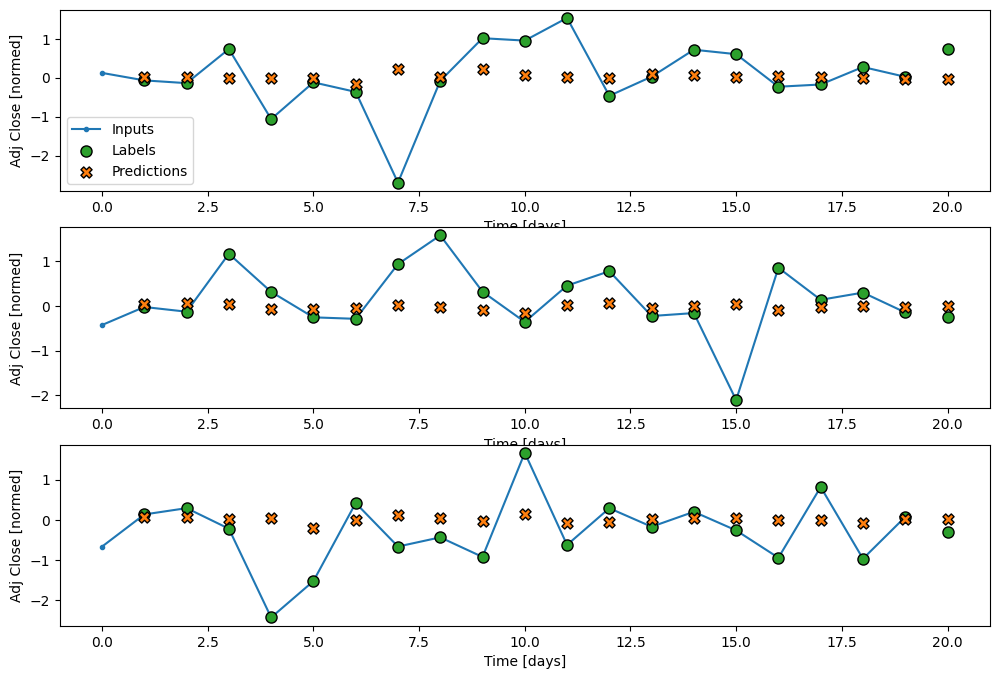

In [ ]:
wide_window.windows[0].plot(lstm_model)

### Other LSTMs

In [ ]:
lstm_model_2 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

lstm_model_3 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

lstm_model_4 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [ ]:
models = [lstm_model_2, lstm_model_3, lstm_model_4]
names = ["LSTM_2", "LSTM_3", "LSTM_4"]

for i, model in enumerate(models):
    history = compile_and_fit(model, wide_window)

    IPython.display.clear_output()
    val_performance[names[i]] = model.evaluate(wide_window.val)
    performance[names[i]] = model.evaluate(wide_window.test, verbose=0)

301/301 [==============================] - 2s 6ms/step - loss: 1.9497 - mean_absolute_error: 0.9058


## Performance

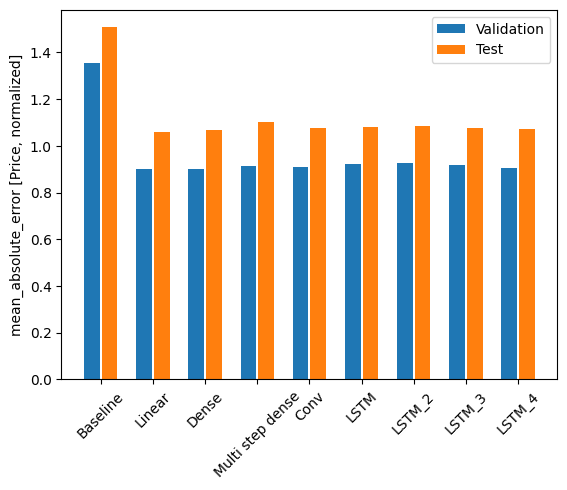

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
